# Finance Application
This application uses a Flax BNN with stochastic Stein VI to predict buy/sell signals on historical stock-data. We then proceed with a backtest to find out how our model would have performed on out-of-sample data.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from flax import linen as nn

import warnings
warnings.filterwarnings('ignore')

import sys, os
sys.path.insert(0, os.path.abspath(".."))
from modules.evaluation_functions.bnn_functions import *
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))


from modules.application_functions.finance_functions import *

c:\Users\Luis\anaconda3\envs\finbridge\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Downloading historical stock prices, using the Yahoo-Finance package (We use the S&P500/SPY):

In [2]:
target = "SPY"
daily_prices = yf.download(target)
full_df = daily_prices["2005-01-01":]
full_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,83.623367,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,82.601562,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031548,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448631,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330444,55847700
...,...,...,...,...,...,...
2024-02-29,508.070007,509.739990,505.350006,508.079987,508.079987,83924800
2024-03-01,508.980011,513.289978,508.559998,512.849976,512.849976,76805900
2024-03-04,512.030029,514.200012,512.000000,512.299988,512.299988,49799300


Checking for NAs:

In [3]:
errors=full_df.isna().any(axis=1)
errors[errors==True]

Series([], dtype: bool)

Creating buy/sell signals on the data, using the triple-barrier-method:

In [4]:
investment_horizon = 10
bound_volas = [2, 1.5]

full_df = yfinance_labeler(full_df, investment_horizon, bound_volas)
full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,upper_bound,lower_bound
Date,,,,,,,,,,
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031548,65667300,0.003761,1,118.897672,117.344250
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448631,47814700,0.008964,0,120.736536,117.015099
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330444,55847700,0.007267,0,120.161351,117.148991
2005-01-10,118.339996,119.459999,118.339996,119.000000,82.719696,56563300,0.007247,0,120.724756,117.706433
2005-01-11,118.639999,118.739998,117.989998,118.180000,82.149712,63099700,0.006776,0,119.781584,116.978813
...,...,...,...,...,...,...,...,...,...,...
2024-02-14,496.790009,499.070007,494.399994,498.570007,498.570007,68387800,0.007980,1,506.526846,492.602378
2024-02-15,499.290009,502.200012,498.799988,502.010010,502.010010,61683000,0.007751,1,509.791976,496.173535
2024-02-16,501.700012,502.869995,498.750000,499.510010,499.510010,75461200,0.007682,1,507.184173,493.754387


Plotting the buy-signals since 2022 for demonstration:

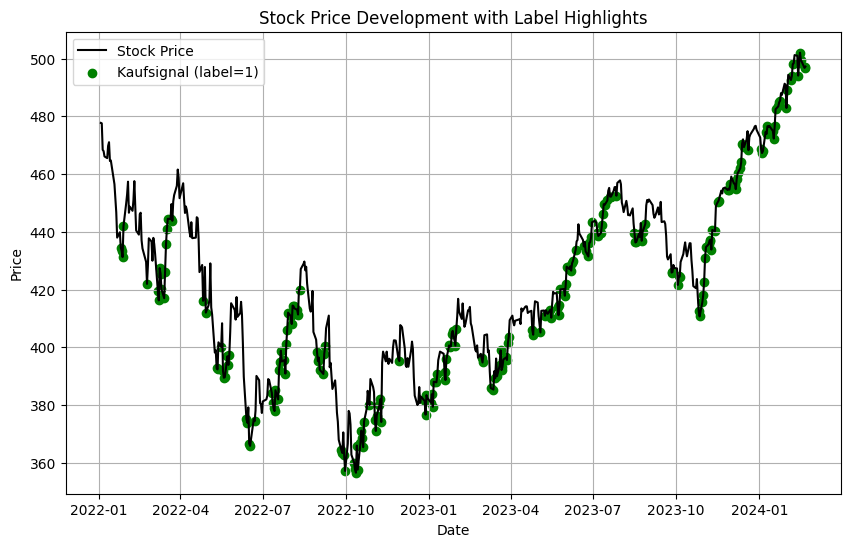

In [5]:
plot_df = full_df["2022-01-01":]

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[plot_df['label'] == 1].index, plot_df[plot_df['label'] == 1]['Close'], color='green', label='Kaufsignal (label=1)')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Creating more indicator variables using the ichimoku-cloud-system:

In [6]:
full_df = ichimoku(full_df)
full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,upper_bound,lower_bound,...,tenkan_sen_higher_cloud,kijun_sen_higher_cloud,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031548,65667300,0.003761,1,118.897672,117.344250,...,0,0,NaN,NaN,0,0,0,0,0,0
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448631,47814700,0.008964,0,120.736536,117.015099,...,0,0,NaN,NaN,0,0,0,0,0,0
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330444,55847700,0.007267,0,120.161351,117.148991,...,0,0,NaN,NaN,0,0,0,0,0,0
2005-01-10,118.339996,119.459999,118.339996,119.000000,82.719696,56563300,0.007247,0,120.724756,117.706433,...,0,0,NaN,NaN,0,0,0,0,0,0
2005-01-11,118.639999,118.739998,117.989998,118.180000,82.149712,63099700,0.006776,0,119.781584,116.978813,...,0,0,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14,496.790009,499.070007,494.399994,498.570007,498.570007,68387800,0.007980,1,506.526846,492.602378,...,1,1,27.682503,17.967506,0,0,0,0,0,0
2024-02-15,499.290009,502.200012,498.799988,502.010010,502.010010,61683000,0.007751,1,509.791976,496.173535,...,1,1,27.905014,17.725006,0,0,0,0,0,0
2024-02-16,501.700012,502.869995,498.750000,499.510010,499.510010,75461200,0.007682,1,507.184173,493.754387,...,1,1,28.150009,17.725006,0,0,0,0,0,0


Creating percentage-changes and dropping columns for the training:

In [7]:
full_df['close_pct'] = full_df['Close'].pct_change(1)
full_df['Volume_pct'] = full_df['Volume'].pct_change(1)

In [8]:
full_df.dropna(inplace=True)
backtest_df = full_df.copy()
full_df.drop(['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', "upper_bound", "lower_bound"], axis=1, inplace=True)

In [9]:
full_df

,vola,label,tenkan_sen_perc,kijun_sen_perc,senkou_span_a_perc,senkou_span_b_perc,tenkan_sen_higher_close,kijun_sen_higher_close,senkou_span_a_higher_close,senkou_span_b_higher_close,...,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud,close_pct,Volume_pct
Date,,,,,,,,,,,,,,,,,,,,,
2005-04-28,0.009680,1,0.000000,0.000000,-0.004760,0.000000,1,1,1,1,...,-4.650002,-3.404999,0,0,0,0,0,1,-0.012538,-0.138478
2005-04-29,0.010307,0,0.000000,0.000000,-0.000627,0.000000,0,1,1,1,...,-4.650002,-3.404999,0,0,0,0,0,0,0.013573,0.434763
2005-05-02,0.009966,0,0.000000,0.000000,-0.000543,0.000000,0,1,1,1,...,-4.650002,-3.404999,0,0,0,0,0,0,0.005616,-0.461252
2005-05-03,0.009490,0,0.002171,0.000000,0.000000,0.000000,0,0,1,1,...,-4.400002,-3.404999,0,0,0,0,0,0,0.001718,0.534996
2005-05-04,0.009294,0,0.003899,0.000000,-0.004810,-0.000501,0,0,1,1,...,-3.889999,-3.344997,0,0,0,0,0,0,0.007719,-0.057495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14,0.007980,1,0.005571,0.001616,0.000000,0.000000,0,0,0,0,...,27.682503,17.967506,0,0,0,0,0,0,0.009088,-0.395329
2024-02-15,0.007751,1,0.000937,0.000000,0.000517,0.000000,0,0,0,0,...,27.905014,17.725006,0,0,0,0,0,0,0.006900,-0.098041
2024-02-16,0.007682,1,0.000493,0.000000,0.000000,0.000000,0,0,0,0,...,28.150009,17.725006,0,0,0,0,0,0,-0.004980,0.223371


Creating our test- and train-datasets:

In [10]:
test_begin = "2021-01-01"
train_df = full_df[:test_begin]
test_df = full_df[test_begin:]

In [11]:
Xs_train = train_df.drop('label', axis=1).values
Xs_test = test_df.drop('label', axis=1).values
Ys_train = train_df['label'].values
Ys_test = test_df['label'].values

# MLP
Creating the Flax BNN:

In [12]:
# MLP params
hidden_layer_width = 15
n_hidden_layers = 5

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

Training our model with stochastic Stein VI:

In [13]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid= None, num_steps=750,batch_size_particles = 75, batch_size_data = 64, num_particles=400
    )

Ys_pred_train, Ys_pred_test, _, Ys_probabilities_train, Ys_probabilities_test = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

100%|██████████| 750/750 [04:54<00:00,  2.55it/s]


Adjusting the threshhold to classify signals as "buy", according to what would have been best on the train dataset:

In [14]:
#Create a Precision/Recall curve for our training data
precision_train, recall_train, pr_thresholds_train = skm.precision_recall_curve(Ys_train, Ys_probabilities_train)
fscore_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

#Find optimal threshhold on PR curve train
ix = np.argmax(fscore_train)
optimal_threshold = pr_thresholds_train[ix]
optimal_threshold

0.3825

In [15]:
test_signal_predictions_adj = Ys_probabilities_test > optimal_threshold

Plotting the found signals on the test-dataset:

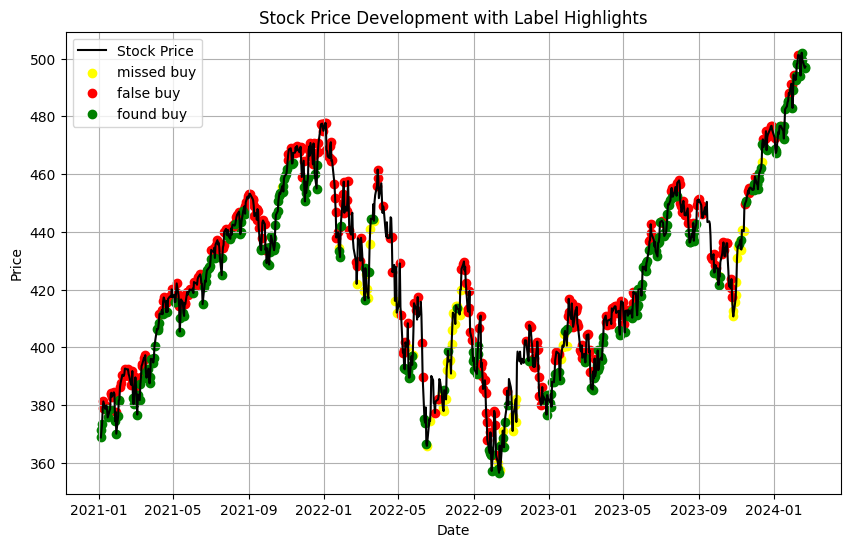

In [16]:
# Add Close prices back to df to see the development
plot_df = backtest_df[test_begin:]
plot_df["signal"] = test_signal_predictions_adj.astype(int)

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)]['Close'], color='yellow', label='missed buy')
plt.scatter(plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)]['Close'], color='red', label='false buy')
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)]['Close'], color='green', label='found buy')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Showing Accuracies for the train- and test-datasets. Keep in mind that those numbers are no statement about the profitability of this strategy. 

In [17]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Train accuracy = 59.55%
Test accuracy = 58.88%


# Backtest
Running a backtest using the triple-barrier-method and our found signals on the test-dataset:

In [18]:
i = 0
cash = plot_df["Close"][0]
percentage_invested = 0.5

cash_history = []
while i < (len(plot_df)-investment_horizon):
    cash_history.append(cash)
    if plot_df["signal"][i] == 1:
        invest_sum = percentage_invested*cash
        cash_vorr = cash - invest_sum
        buy_price = plot_df["Close"][i]

        z=1
        while z <= investment_horizon:
            if plot_df["Close"][i+z] >= plot_df["upper_bound"][i]:
                sell_price = plot_df["Close"][i+z]
                perc_change = sell_price / buy_price
                invest_sum_updated = invest_sum*perc_change
                cash = cash_vorr + invest_sum_updated
                cash_history.append(cash)
                break
            elif plot_df["Close"][i+z] <= plot_df["lower_bound"][i]:
                sell_price = plot_df["Close"][i+z]
                perc_change = sell_price / buy_price
                invest_sum_updated = invest_sum*perc_change
                cash = cash_vorr + invest_sum_updated
                cash_history.append(cash)
                break
            elif (z == investment_horizon):
                sell_price = plot_df["Close"][i+z]
                perc_change = sell_price / buy_price
                invest_sum_updated = invest_sum*perc_change
                cash = cash_vorr + invest_sum_updated
                cash_history.append(cash)
                break
            z = z+1
            cash_history.append(cash)
        i = i+z
    i = i+1

plot_df = plot_df[:i]
plot_df["cash"] = cash_history

Visual analysis of the performance on test-dataset of the stock and the triple-barrier-method strategy. We compare the daily cash amount one would have with the strategy vs. just buying the stock once at the beginning and holding it to the end.

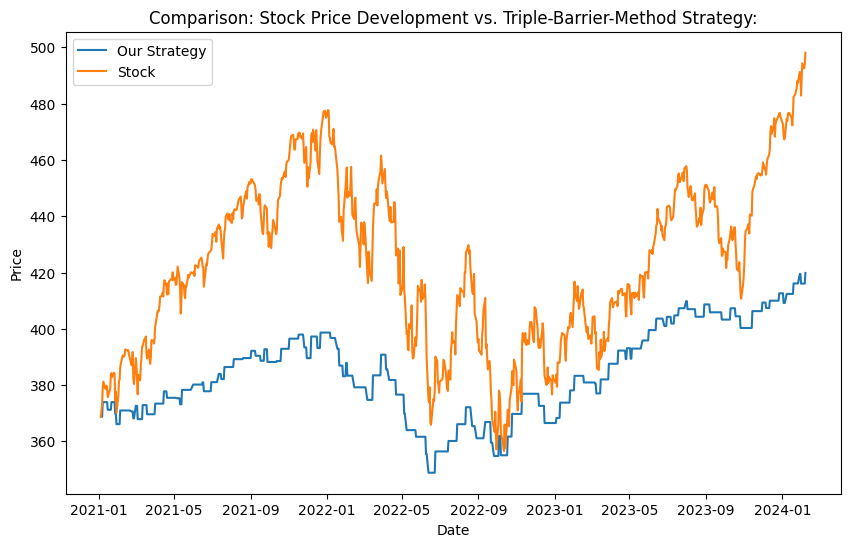

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['cash'], label = "Our Strategy")
plt.plot(plot_df.index, plot_df['Close'], label = "Stock")
plt.title('Comparison: Stock Price Development vs. Triple-Barrier-Method Strategy:')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

**Quantitative analysis of the backtest results:**

</br>First, we compare the **total returns** of just holding the stock vs. the strategy (over the whole test-dataset)

In [20]:
total_return_stock = (plot_df['Close'][len(plot_df)-1] / plot_df['Close'][0] -1)*100
total_return_strategy = (plot_df['cash'][len(plot_df)-1] / plot_df['cash'][0] -1)*100


print(f"Total return of the stock: {total_return_stock:.2f}%")
print(f"Total return of the strategy: {total_return_strategy:.2f}%")


Total return of the stock: 35.06%
Total return of the strategy: 13.84%


Next, we compare their **volatilities** (over daily returns):

In [21]:
vola_stock = np.std(plot_df['Close'].pct_change().dropna())
vola_strategy = np.std(plot_df['cash'].pct_change().dropna())

print(f"Volatility of the stock: {vola_stock:.4f}")
print(f"Volatility of the strategy: {vola_strategy:.4f}")

Volatility of the stock: 0.0110
Volatility of the strategy: 0.0045


To take into account the returns and volatilities, we now also compare their **sharpe-ratios**:
</br>(as (average_return - risk_free_rate) / volatility), risk_free_rate=0 for simplicity )

In [22]:
sharpe_ratio_stock = np.mean(plot_df['Close'].pct_change().dropna()) / vola_stock
sharpe_ratio_strategy = np.mean(plot_df['cash'].pct_change().dropna()) / vola_strategy

print(f"Sharpe-ratio of the stock: {sharpe_ratio_stock:.4f}")
print(f"Sharpe-ratio of the strategy: {sharpe_ratio_strategy:.4f}")

Sharpe-ratio of the stock: 0.0406
Sharpe-ratio of the strategy: 0.0395


Even though our strategy led to lower total returns, the sharpe-ratios are quite similar, because the strategy is less volatile.